

## Web scraping and analysis

 We will use a package called `BeautifulSoup` to collect the data from the web. Once we have collected our data and saved it into a local `.csv` file we can start with the analysis.

### Scraping data from Skytrax

If you visit [https://www.airlinequality.com] you can see that there is a lot of data there. For this task, we are only interested in reviews related to British Airways and the Airline itself.

If you navigate to this link: [https://www.airlinequality.com/airline-reviews/british-airways] you will see this data. Now, we can use `Python` and `BeautifulSoup` to collect all the links to the reviews and then to collect the text data on each of the individual review links.

In [1]:
import re
import string
from wordcloud import WordCloud
import zipfile

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 10
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())

    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews


In [4]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,"Not Verified | On March 1st, I flew from Ber..."
1,Not Verified | The WORST customer experience! ...
2,Not Verified | Had to cancel my flight month...
3,✅ Trip Verified | Flight cancelled with no rea...
4,✅ Trip Verified | This is a route I fly regula...


In [5]:
df.to_csv("df.csv")

The loops above collected 1000 reviews by iterating through the paginated pages on the website. However, if you want to collect more data, try increasing the number of pages!

 The next thing to do is clean this data to remove any unnecessary text from each of the rows. For example, "✅ Trip Verified" can be removed from each row if it exists, as it's not relevant to what we want to investigate.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   reviews  1000 non-null   object
dtypes: object(1)
memory usage: 7.9+ KB


In [7]:
df.head()

,reviews
0,"Not Verified | On March 1st, I flew from Ber..."
1,Not Verified | The WORST customer experience! ...
2,Not Verified | Had to cancel my flight month...
3,✅ Trip Verified | Flight cancelled with no rea...
4,✅ Trip Verified | This is a route I fly regula...


### TASK 2: Data Cleaning

In [8]:
import pandas as pd



# Remove the comma from the name column
df['reviews'] = df['reviews'].str.replace('Trip Verified', '')

print(df)

                                               reviews
0    Not Verified |   On March 1st, I flew from Ber...
1    Not Verified | The WORST customer experience! ...
2    Not Verified |   Had to cancel my flight month...
3    ✅  | Flight cancelled with no reason given les...
4    ✅  | This is a route I fly regularly. Used fir...
..                                                 ...
995  ✅  |  London to Milan. Evening outbound flight...
996  ✅  |  The connecting flight to Johannesburg wa...
997  ✅  | London Heathrow to Los Angeles. Very nice...
998  ✅  | CPT is definitely getting its act togethe...
999  ✅  |  Sofia to Belfast via London. The legroom...

[1000 rows x 1 columns]


In [9]:

# Remove the comma from the name column
df['reviews'] = df['reviews'].str.replace('✅', '')

print(df)

                                               reviews
0    Not Verified |   On March 1st, I flew from Ber...
1    Not Verified | The WORST customer experience! ...
2    Not Verified |   Had to cancel my flight month...
3      | Flight cancelled with no reason given less...
4      | This is a route I fly regularly. Used firs...
..                                                 ...
995    |  London to Milan. Evening outbound flight ...
996    |  The connecting flight to Johannesburg was...
997    | London Heathrow to Los Angeles. Very nice ...
998    | CPT is definitely getting its act together...
999    |  Sofia to Belfast via London. The legroom ...

[1000 rows x 1 columns]


In [10]:

# Remove the comma from the name column
df['reviews'] = df['reviews'].str.replace('| ', '')

print(df)

                                               reviews
0    Not Verified |   On March 1st, I flew from Ber...
1    Not Verified The WORST customer experience! Br...
2    Not Verified |   Had to cancel my flight month...
3      Flight cancelled with no reason given less t...
4      This is a route I fly regularly. Used first ...
..                                                 ...
995     London to Milan. Evening outbound flight wi...
996     The connecting flight to Johannesburg was o...
997    London Heathrow to Los Angeles. Very nice ex...
998    CPT is definitely getting its act together: ...
999     Sofia to Belfast via London. The legroom on...

[1000 rows x 1 columns]


Remove HTML tags, URLs, and non-alphanumeric characters from the reviews. We do that with the help of the remove_tags function, and Regex functions are used for easy string manipulation

In [11]:
def tokens(words):
    words = re.sub("[^a-zA-Z]"," ", words)
    text = words.lower().split()
    return " ".join(text)

We also need to remove stopwords from the corpus. Commonly used words like ‘and’, ‘the’, and ‘at’ are stopwords that do not add any special meaning or significance to a sentence. NLTK provides a list of stopwords, and you can remove them from the corpus using the following code

In [12]:
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


We did not perform perform lemmatization on the text as the dataset was not too much otherwise I would have done it. Lemmatization is a useful technique in NLP to obtain the root form of words, known as lemmas. For example, the words “reading,” “reads,” and “read” all lemma to “read.” This approach saves unnecessary computational overhead in deciphering entire words, as their meanings are well-expressed by their lemmas. We perform lemmatization using the WordNetLemmatizer() from nltk. The text is first broken into words using the WhitespaceTokenizer() from nltk. We write a function lemmatize_text to perform lemmatization on the individual tokens.

In [13]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [14]:
df['reviews'] = df['reviews'].apply(tokens)
df.head()

,reviews
0,not verified on march st i flew berlin s o pau...
1,not verified the worst customer experience bri...
2,not verified had cancel flight months advance ...
3,flight cancelled reason given less h departure...
4,this route i fly regularly used first class se...


To change from unlabelled to labelled dataset:

 I'll propose the sentence or tweet in this context to be analysed for polarity. This can be done using the textblob library. It can be installed as pip install -U textblob. Once the text data polarity is found, it can be assigned as a separate column in the dataframe. Subsequently, the sentence polarity can then be used for further analysis.

In [15]:
from textblob import TextBlob
df['sentiment'] = df['reviews'].apply(lambda Tweet: TextBlob(Tweet).sentiment)
print(df)

                                               reviews  \
0    not verified on march st i flew berlin s o pau...   
1    not verified the worst customer experience bri...   
2    not verified had cancel flight months advance ...   
3    flight cancelled reason given less h departure...   
4    this route i fly regularly used first class se...   
..                                                 ...   
995  london milan evening outbound flight board spa...   
996  the connecting flight johannesburg older prope...   
997  london heathrow los angeles very nice experien...   
998  cpt definitely getting act together ba s galle...   
999  sofia belfast via london the legroom sofia hea...   

                                       sentiment  
0    (-0.04214285714285714, 0.41833333333333333)  
1      (0.00448717948717948, 0.6782051282051283)  
2                                 (0.135, 0.335)  
3      (-0.4240740740740741, 0.5240740740740741)  
4      (0.2656862745098039, 0.49079939668174954)

In [16]:
df1=pd.DataFrame(df['sentiment'].tolist(), index= df.index)

From the sentiment column (in the above output), we can see the sentiment column is categorized between two — Polarity and Subjectivity.

Polarity is a float value within the range [-1.0 to 1.0] where 0 indicates neutral, +1 indicates a very positive sentiment and -1 represents a very negative sentiment.

Subjectivity is a float value within the range [0.0 to 1.0] where 0.0 is very objective and 1.0 is very subjective. Subjective sentence expresses some personal feelings, views, beliefs, opinions, allegations, desires, beliefs, suspicions, and speculations where as Objective sentences are factual.

Notice, the sentiment column is a tuple. So we can split it into two columns like, df1=pd.DataFrame(df['sentiment'].tolist(), index= df.index). Now, we can create a new dataframe to which I'll append the split columns as shown;

In [17]:
df_new = df
df_new['polarity'] = df1['polarity']
df_new.polarity = df1.polarity.astype(float)
df_new['subjectivity'] = df1['subjectivity']
df_new.subjectivity = df1.polarity.astype(float)

*Finally*, based on the sentence polarity found earlier, we can now add a label to the dataframe, which will indicate if the review is positive, negative or neutral.

In [18]:
import numpy as np
conditionList = [
    df_new['polarity'] == 0,
    df_new['polarity'] > 0,
    df_new['polarity'] < 0]
choiceList = ['neutral', 'positive', 'negative']
df_new['label'] = np.select(conditionList, choiceList, default='no_label')
print(df_new)


                                               reviews  \
0    not verified on march st i flew berlin s o pau...   
1    not verified the worst customer experience bri...   
2    not verified had cancel flight months advance ...   
3    flight cancelled reason given less h departure...   
4    this route i fly regularly used first class se...   
..                                                 ...   
995  london milan evening outbound flight board spa...   
996  the connecting flight johannesburg older prope...   
997  london heathrow los angeles very nice experien...   
998  cpt definitely getting act together ba s galle...   
999  sofia belfast via london the legroom sofia hea...   

                                       sentiment  polarity  subjectivity  \
0    (-0.04214285714285714, 0.41833333333333333) -0.042143     -0.042143   
1      (0.00448717948717948, 0.6782051282051283)  0.004487      0.004487   
2                                 (0.135, 0.335)  0.135000      0.135000   

In [19]:
df_labelled = df.drop(columns=['sentiment', 'polarity', 'subjectivity'])
print(df_labelled)

                                               reviews     label
0    not verified on march st i flew berlin s o pau...  negative
1    not verified the worst customer experience bri...  positive
2    not verified had cancel flight months advance ...  positive
3    flight cancelled reason given less h departure...  negative
4    this route i fly regularly used first class se...  positive
..                                                 ...       ...
995  london milan evening outbound flight board spa...  positive
996  the connecting flight johannesburg older prope...  positive
997  london heathrow los angeles very nice experien...  positive
998  cpt definitely getting act together ba s galle...  positive
999  sofia belfast via london the legroom sofia hea...  negative

[1000 rows x 2 columns]


**Sentiments Visualisation**



In [20]:

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Text(0.5, 1.0, 'Proportion Sentiments')

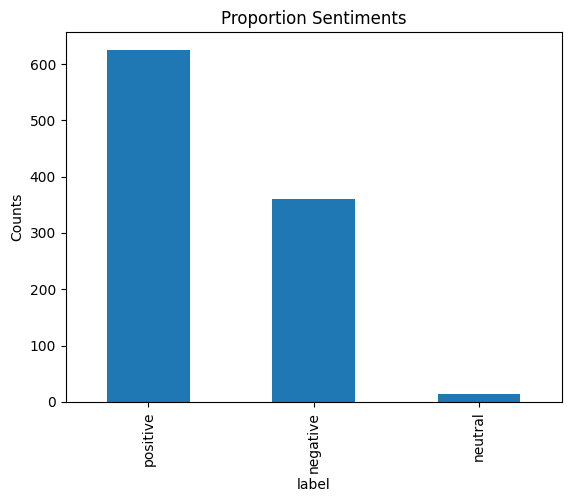

In [21]:
df_labelled["label"].value_counts().plot(kind='bar')
plt.xlabel("label")
plt.ylabel("Counts")
plt.title("Proportion Sentiments")

**Finding most comment words in the postive sentiments using wordcloud**

In [22]:
positive = df_labelled[df_labelled .label== 'positive']
negative = df_labelled[df_labelled .label== 'negative']
positive.head()


,reviews,label
1,not verified the worst customer experience bri...,positive
2,not verified had cancel flight months advance ...,positive
4,this route i fly regularly used first class se...,positive
6,british airways new club suite marked improvem...,positive
7,four pleasant time flights friendly helpful st...,positive


In [23]:
negative.head()

,reviews,label
0,not verified on march st i flew berlin s o pau...,negative
3,flight cancelled reason given less h departure...,negative
5,while ba may made positive improvements club w...,negative
9,flight delayed hour due bad weather around jfk...,negative
11,the worst airline i ve ever flown could check ...,negative


In [24]:
positive_words =[]

for review in positive.reviews:
    positive_words.append(review)
positive_words = ' '.join(positive_words)
positive_words[:500]

'not verified the worst customer experience british airways ba effectively robbing people they help show compassion my partner i fell ill doctor s note stating fly ba said they d hold flight amount voucher valid year fair enough caveat which stated us must call usable holiday packages however using voucher nightmare we can t use tickets original long haul refuse refund half amount ba s customer service awful rude effectively stealing us this policy must stop we feel held hostage solution not veri'

In [25]:
negative_words = []

for review in negative.reviews:
    negative_words.append(review)
negative_words = ' '.join(negative_words)
negative_words[:500]

'not verified on march st i flew berlin s o paulo ba encountered several issues my first flight delayed several hours causing miss connection london heathrow upon arriving airport midnight i given hotel voucher however hotel designated ba rudely denied check in claiming fully booked i return heathrow am found different hotel paying taxi pocket as result complications i arrived s o paulo hours late despite efforts assert rights seek reimbursement taxi ba s customer service extremely poor their pho'

**Common Positive Words in the Review**

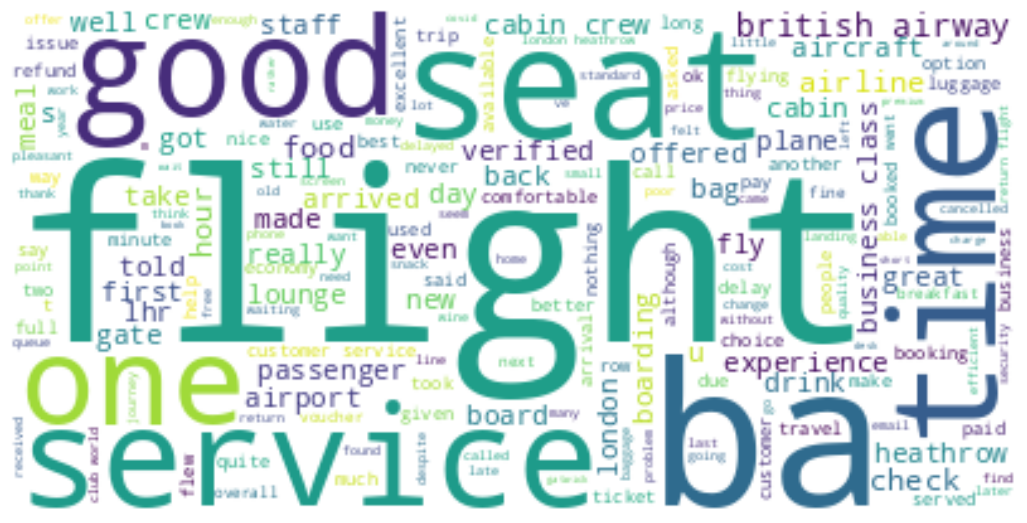

In [26]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_words))

wordcloud.generate(positive_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

**Common Negative Words in the Review**

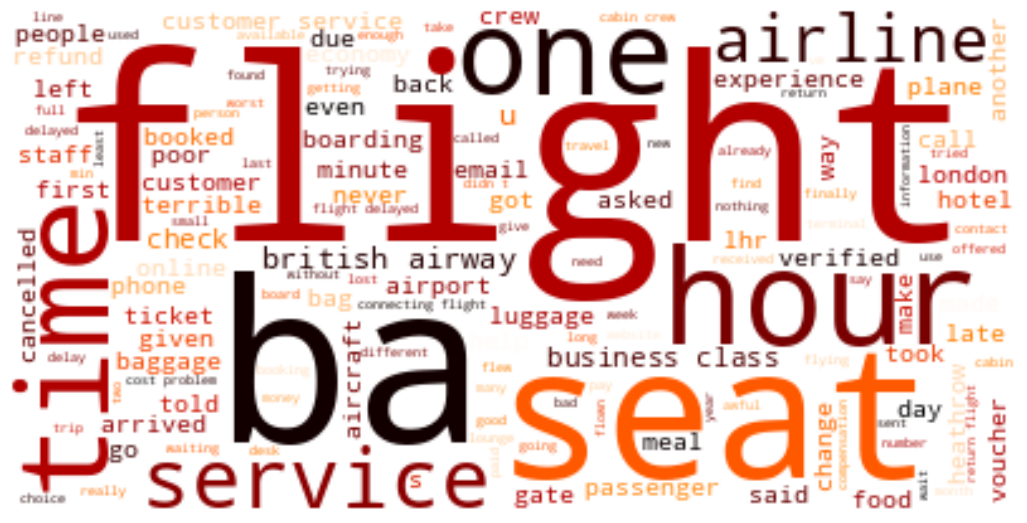

In [27]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words), colormap='gist_heat')

wordcloud.generate(negative_words)

plt.figure(figsize=(13,13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
df_labelled['category_id'] = df_labelled['label'].factorize()[0]
from io import StringIO
category_id_df = df_labelled[['label', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'label']].values)


In [29]:
df_labelled

,reviews,label,category_id
0,not verified on march st i flew berlin s o pau...,negative,0
1,not verified the worst customer experience bri...,positive,1
2,not verified had cancel flight months advance ...,positive,1
3,flight cancelled reason given less h departure...,negative,0
4,this route i fly regularly used first class se...,positive,1
...,...,...,...
995,london milan evening outbound flight board spa...,positive,1
996,the connecting flight johannesburg older prope...,positive,1
997,london heathrow los angeles very nice experien...,positive,1
998,cpt definitely getting act together ba s galle...,positive,1


**Encoding reviews using TFIDFVectorizer**

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=4, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')

features = tfidf.fit_transform(df_labelled.reviews).toarray()
labels = df_labelled.category_id
features.shape

(1000, 3569)

Obtaining Common Unigrams and Bigrams from reviews

In [31]:
from sklearn.feature_selection import chi2
import numpy as np

N = 2
for Product, category_id in sorted(category_to_id.items()):
  features_chi2 = chi2(features, labels == category_id)
  indices = np.argsort(features_chi2[0])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
  bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
  print("# '{}':".format(Product))
  print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:])))
  print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:])))

# 'negative':
  . Most correlated unigrams:
       . good
       . worst
  . Most correlated bigrams:
       . flight delayed
       . worst airline
# 'neutral':
  . Most correlated unigrams:
       . treating
       . require
  . Most correlated bigrams:
       . refund voucher
       . verified flight
# 'positive':
  . Most correlated unigrams:
       . worst
       . good
  . Most correlated bigrams:
       . flight delayed
       . worst airline


**MODELLING**

Using the following classification models:

Logistic Regression, Naive Bayes, Support Vector Machine, Random Forest, Ada Boosting. To run machine learning algorithms we need to convert text files into numerical feature vectors. We will use bag of words model for our analysis.

First we spliting the data into train and test sets:

In [32]:
X = df_labelled['reviews']
y = df_labelled['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)

clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [34]:
print(clf.predict(count_vect.transform(["a very full flight made premium economy feel a little less premium than you should expect for the price however the smaller cabin configuration and slightly roomier seating made the journey relaxing enough catering was pretty good and the inflight service was efficient and friendly arrived on time and no delays with baggage delivery no complaints as pe served it s function for the relatively short hr flight i am surprised to be able to give a favourable review of the flight european business"])))

['positive']


In [35]:
from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),

    MultinomialNB(),
    LogisticRegression(random_state=0),

]
CV = 2
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

In [36]:
cv_df

,model_name,fold_idx,accuracy
0,RandomForestClassifier,0,0.624
1,RandomForestClassifier,1,0.626
2,MultinomialNB,0,0.654
3,MultinomialNB,1,0.644
4,LogisticRegression,0,0.724
5,LogisticRegression,1,0.694


**Accuracy BoxPlot**

<ipython-input-37-3e6f57e22e59>:3: FutureWarning: Use "auto" to set automatic grayscale colors. From v0.14.0, "gray" will default to matplotlib's definition.
  sns.stripplot(x='model_name', y='accuracy', data=cv_df,


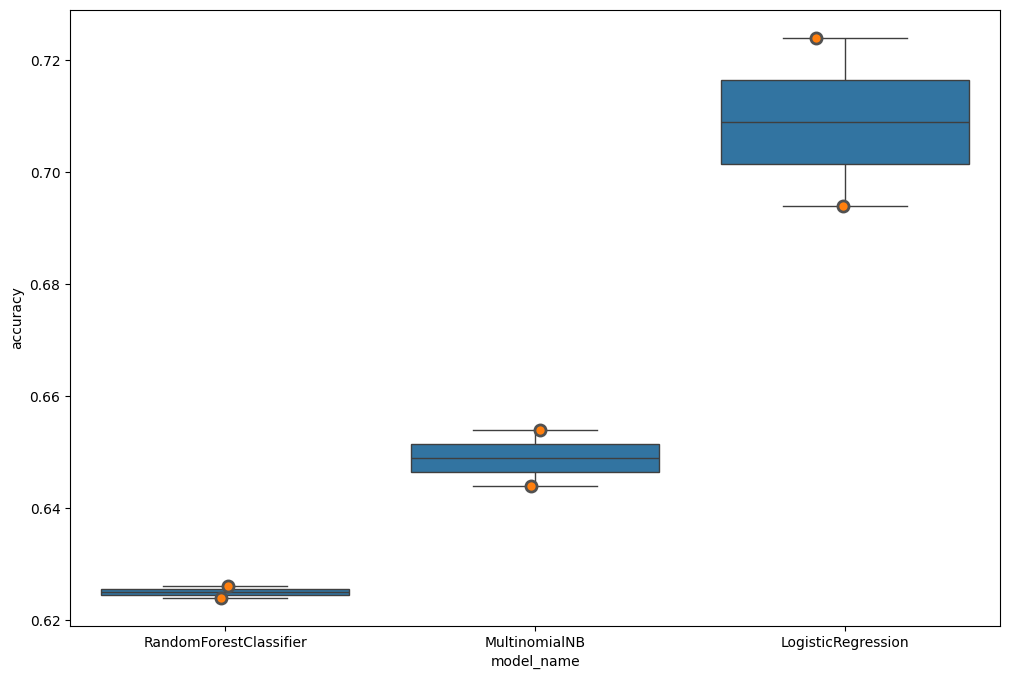

In [37]:
fig = plt.figure(figsize=(12,8))
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df,
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

**Mean of Accuracy**

In [38]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LogisticRegression        0.709
MultinomialNB             0.649
RandomForestClassifier    0.625
Name: accuracy, dtype: float64

**Final Modelling with Logistics Regression**

In [39]:
#first we split the data into testing and training
from sklearn.model_selection import train_test_split

model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(features, labels, df.index, test_size=0.15, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

**Confusion Matrix**

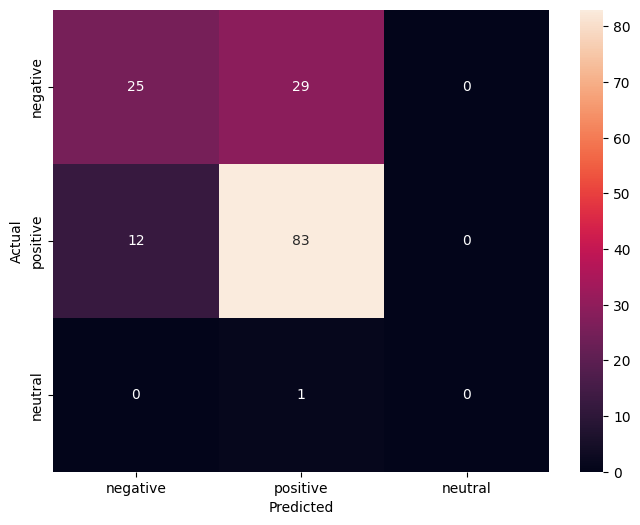

In [40]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.label.values, yticklabels=category_id_df.label.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

**Making Predictions using IPython.display Package**

In [41]:
from IPython.display import display

for predicted in range(conf_mat.shape[1]):
  for actual in range(conf_mat.shape[0]):
    if predicted != actual and conf_mat[actual, predicted] >= 0:
      print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'reviews']])
      print('')

      #from IPython.display import display

#for predicted in category_id_df.category_id:
  #for actual in category_id_df.category_id:
    #if predicted != actual and conf_mat[actual, predicted] >= 0:
      #print("'{}' predicted as '{}' : {} examples.".format(id_to_category[actual], id_to_category[predicted], conf_mat[actual, predicted]))
      #display(df.loc[indices_test[(y_test == actual) & (y_pred == predicted)]][['label', 'reviews']])
      #print('')

'positive' predicted as 'negative' : 12 examples.


,label,reviews
553,positive,one would think number crises ba incurs would ...
578,positive,not verified over past years i flown british a...
906,positive,not verified i often flown british airways con...
1,positive,not verified the worst customer experience bri...
635,positive,not verified i ve book six flights ba recently...
316,positive,we flown repeatedly british airways one world ...
97,positive,very poor business class product ba even close...
523,positive,i incredible rude check staff british airways ...
255,positive,i booked first country trip take husband surpr...
122,positive,i recently delay british airways bru lhr due s...



'neutral' predicted as 'negative' : 0 examples.


,label,reviews



'negative' predicted as 'positive' : 29 examples.


,label,reviews
672,negative,not verified cancellations month applying vouc...
306,negative,obviously many airlines gone downhill recent y...
14,negative,ba cancelled flight tokyo lhr i booked next da...
31,negative,manchester copenhagen via london th april airc...
481,negative,this new route ba introduced beginning june se...
883,negative,phoenix tel aviv via london the return london ...
103,negative,not verified beware ba provide refund due seri...
710,negative,at check in desk t heathrow told ba staff swed...
614,negative,not verified poorly mismanaged services time d...
736,negative,london cape town gone days british airways gre...



'neutral' predicted as 'positive' : 1 examples.


,label,reviews
738,neutral,johannesburg dublin via london i get counter r...



'negative' predicted as 'neutral' : 0 examples.


,label,reviews



'positive' predicted as 'neutral' : 0 examples.


,label,reviews


In [42]:
model.fit(features, labels)

LogisticRegression()

Obtaining Unigrams and Bigrams again

In [43]:
N = 2
for Reason, category_id in sorted(category_to_id.items()):
  indices = np.argsort(model.coef_[category_id])
  feature_names = np.array(tfidf.get_feature_names_out())[indices]
  unigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 1][:N]
  bigrams = [v for v in reversed(feature_names) if len(v.split(' ')) == 2][:N]
  print("# '{}':".format(Reason))
  print("  . Top unigrams:\n       . {}".format('\n       . '.join(unigrams)))
  print("  . Top bigrams:\n       . {}".format('\n       . '.join(bigrams)))

# 'negative':
  . Top unigrams:
       . worst
       . terrible
  . Top bigrams:
       . business class
       . flight delayed
# 'neutral':
  . Top unigrams:
       . luggage
       . require
  . Top bigrams:
       . verified flight
       . hand luggage
# 'positive':
  . Top unigrams:
       . good
       . great
  . Top bigrams:
       . london heathrow
       . cabin crew


**Predictions**

In [44]:
texts = ["a very full flight made premium economy feel a little less premium than you should expect for the price however the smaller cabin configuration and slightly roomier seating made the journey relaxing enough catering was pretty good and the inflight service was efficient and friendly arrived on time and no delays with baggage delivery no complaints as pe served it s function for the relatively short hr flight i am surprised to be able to give a favourable review of the flight european business cla",
         "flight delayed an hour due to bad weather around jfk however this was made up during the flight only to be delayed again by weather over lhr spending an extra hour in the american ba lounge at jfk was not ideal cold environment cold staff indifferent to the travellers needs one area was exceptionally dirty with plates on the tables and napkins strewn on the floor waited for a drink as no one to serve played a game of find the chips crisps which were hidden on a table in a dark corner in one of"]

In [45]:
text_features = tfidf.transform(texts)
predictions = model.predict(text_features)
for text, predicted in zip(texts, predictions):
  print('"{}"'.format(text))
  print("  - Predicted as: '{}'".format(id_to_category[predicted]))
  print("")

"a very full flight made premium economy feel a little less premium than you should expect for the price however the smaller cabin configuration and slightly roomier seating made the journey relaxing enough catering was pretty good and the inflight service was efficient and friendly arrived on time and no delays with baggage delivery no complaints as pe served it s function for the relatively short hr flight i am surprised to be able to give a favourable review of the flight european business cla"
  - Predicted as: 'positive'

"flight delayed an hour due to bad weather around jfk however this was made up during the flight only to be delayed again by weather over lhr spending an extra hour in the american ba lounge at jfk was not ideal cold environment cold staff indifferent to the travellers needs one area was exceptionally dirty with plates on the tables and napkins strewn on the floor waited for a drink as no one to serve played a game of find the chips crisps which were hidden on a 

**Classification Report**

In [46]:
from sklearn import metrics

In [47]:
print(metrics.classification_report(y_test, y_pred, labels=[0,1, 2, 3,4,5,6,7,8], target_names=df_labelled['label'].unique()))

              precision    recall  f1-score   support

    negative       0.68      0.46      0.55        54
    positive       0.73      0.87      0.80        95
     neutral       0.00      0.00      0.00         1

   micro avg       0.72      0.72      0.72       150
   macro avg       0.16      0.15      0.15       150
weighted avg       0.71      0.72      0.70       150



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:2326: UserWarning: labels size, 9, does not match size of target_names, 3
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_divisio

**Glove Modelling**

Cause our data is text data, it has to be converted into numerical form since that’s what the deep learning model expects. To convert sentences into numerical representations we use Tokenizer, which removes punctuation marks and special characters and converts the sentence to lowercase letter.

In [48]:
df_labelled

,reviews,label,category_id
0,not verified on march st i flew berlin s o pau...,negative,0
1,not verified the worst customer experience bri...,positive,1
2,not verified had cancel flight months advance ...,positive,1
3,flight cancelled reason given less h departure...,negative,0
4,this route i fly regularly used first class se...,positive,1
...,...,...,...
995,london milan evening outbound flight board spa...,positive,1
996,the connecting flight johannesburg older prope...,positive,1
997,london heathrow los angeles very nice experien...,positive,1
998,cpt definitely getting act together ba s galle...,positive,1


In [49]:
X = df_labelled['reviews']
y = df_labelled['category_id']

X_train_sentences, X_test_sentences, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

In [50]:
vocab_size = 2000
embedding_dim = 16
max_len = 100
trunction_type='post'
padding_type='post'
oov_token = "<OOV>"

In [51]:
tokenize = Tokenizer(num_words = vocab_size, oov_token=oov_token)
tokenize.fit_on_texts(X_train_sentences)

Word index show us how words are mapped into numbers

In [52]:
word_index = tokenize.word_index

By use texts_to_sequences from the tokenizer we convert the words into sequences so that a complete sequence of numbers can represent every sentence.

In [53]:
X_train = tokenize.texts_to_sequences(X_train_sentences)
X_test = tokenize.texts_to_sequences(X_test_sentences)

In [54]:

X_train_pad = pad_sequences(X_train,maxlen=max_len, padding=padding_type,
                            truncating=trunction_type)

X_test_pad = pad_sequences(X_test,maxlen=max_len, padding=padding_type,
                           truncating=trunction_type)

**Glove Embeddings**


In [55]:
#We use pre-trained word embeddings to create own embedding layer. We loading the Glove embeddings and append them to a dictionary.
#Next we use this dictionary to create an embedding matrix for each word in the training set.


In [56]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2024-07-14 14:24:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-07-14 14:24:00--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-07-14 14:24:00--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [57]:
!unzip glove*.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [58]:
!ls
!pwd

df.csv		   glove.6B.200d.txt  glove.6B.50d.txt	sample_data
glove.6B.100d.txt  glove.6B.300d.txt  glove.6B.zip
/content


In [59]:
embeddings_index = {}
f = open('glove.6B.100d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    try:
       coefs = np.asarray(values[1:], dtype='float32')
       embeddings_index[word] = coefs
    except ValueError:
       pass
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [60]:
num_words = len(word_index) + 1

embedding_matrix = np.zeros((num_words, max_len))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

**Deep Learning Model**

We create a model using embedding layer and Bidirectional LSTM layers. Bidirectional LSTMs are supported in Keras via the Bidirectional layer wrapper and it takes a recurrent layer (e.g. the first LSTM layer) as an argument.

In [61]:
#we create embedding layer
embedding_layer = Embedding(num_words,
                            max_len,
                            weights=[embedding_matrix],
                            input_length=max_len,
                            trainable=False)

In [62]:
model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(embedding_dim, return_sequences=True)),
    Bidirectional(LSTM(embedding_dim)),
    Dense(6, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          649400    
                                                                 
 bidirectional (Bidirection  (None, 100, 32)           14976     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 32)                6272      
 onal)                                                           
                                                                 
 dense (Dense)               (None, 6)                 198       
                                                                 
 dense_1 (Dense)             (None, 1)                 7         
                                                                 
Total params: 670853 (2.56 MB)
Trainable params: 21453 (

In [63]:
#training 10 epochs
history = model.fit(X_train_pad, y_train,
                    batch_size=32,
                    epochs=10,
                    validation_data=(X_test_pad, y_test),
                    verbose=1)

Epoch 1/10
25/25 [==============================] - 16s 324ms/step - loss: 0.6497 - accuracy: 0.6100 - val_loss: 0.6498 - val_accuracy: 0.6150
Epoch 2/10
25/25 [==============================] - 5s 190ms/step - loss: 0.6214 - accuracy: 0.6300 - val_loss: 0.6303 - val_accuracy: 0.6300
Epoch 3/10
25/25 [==============================] - 4s 154ms/step - loss: 0.5870 - accuracy: 0.6525 - val_loss: 0.5758 - val_accuracy: 0.6800
Epoch 4/10
25/25 [==============================] - 2s 94ms/step - loss: 0.5352 - accuracy: 0.7150 - val_loss: 0.5902 - val_accuracy: 0.6550
Epoch 5/10
25/25 [==============================] - 2s 99ms/step - loss: 0.4929 - accuracy: 0.7387 - val_loss: 0.5242 - val_accuracy: 0.7150
Epoch 6/10
25/25 [==============================] - 2s 98ms/step - loss: 0.4565 - accuracy: 0.7613 - val_loss: 0.5182 - val_accuracy: 0.6950
Epoch 7/10
25/25 [==============================] - 3s 103ms/step - loss: 0.4183 - accuracy: 0.7950 - val_loss: 0.5218 - val_accuracy: 0.6950
Epoch 8/

In [64]:
#Predictions on a test set:

loss, accuracy = model.evaluate(X_test_pad,y_test)
print('Test accuracy :', accuracy)

7/7 [==============================] - 0s 54ms/step - loss: 0.5513 - accuracy: 0.7450
Test accuracy : 0.7450000047683716


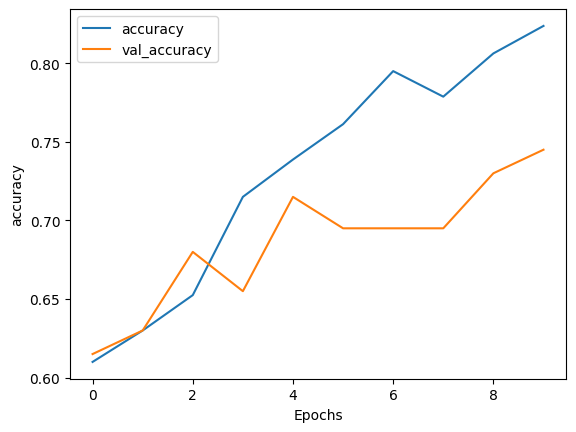

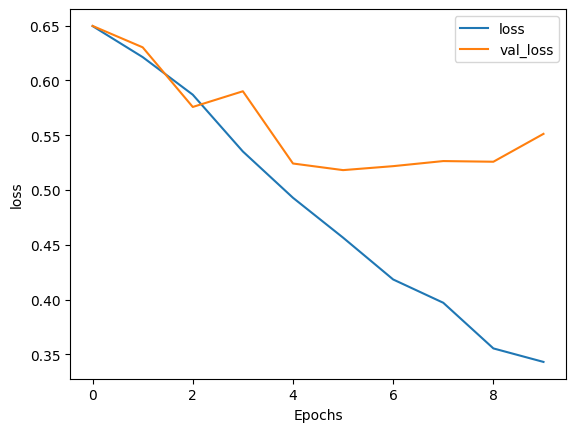

In [65]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

Unseen Reviews
We can use our trained LSTM model for sentiment analysis to determine the sentiment of new unseen  reviews that are not present in the dataset. Before feeding each new text as input to the model, you must tokenize and pad it. The model.predict() function returns the probability of the positive review. If the probability is more significant than 0.5, we consider the study positive; otherwise, it is negative.